In [3]:
from config_paths import OUT, FIGS   # ✅ 直接导入全局路径

C:\Users\Qien Jing\AppData\Local\Temp\ipykernel_25248\55184547.py:35: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(t), np.log(np.maximum(WE,1e-30)), color='tab:red', label="Electric Energy (W_E)")


γ_total (from energy): -6.255e+00  (1/step)


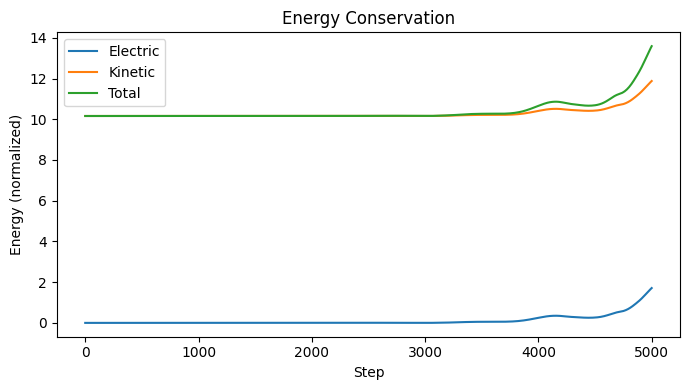

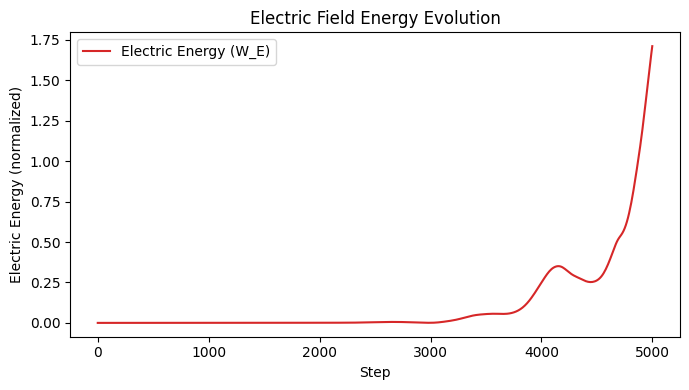

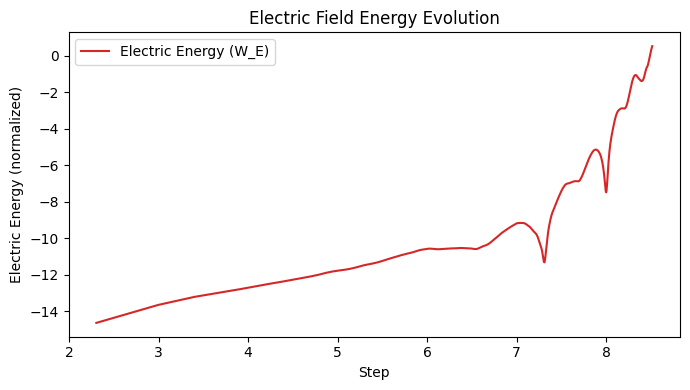

In [6]:
# diagnostics/plot_energy.py
import os, numpy as np, matplotlib.pyplot as plt
from diag_utils import ensure_dir, load_energy, robust_linear_fit
from config_paths import OUT, FIGS   # ✅ 直接导入全局路径

data = load_energy(OUT)
t, WE, WK, WT = data.T

# -------------------------------
# 原有三条曲线：总能量图
# -------------------------------
plt.figure(figsize=(7,4))
plt.plot(t, WE, label="Electric")
plt.plot(t, WK, label="Kinetic")
plt.plot(t, WT, label="Total")
plt.xlabel("Step"); plt.ylabel("Energy (normalized)")
plt.title("Energy Conservation")
plt.legend(); plt.tight_layout()
# plt.savefig(os.path.join(FIGS, "energy_evolution.png"), dpi=150)

# -------------------------------
# ✅ 新增：仅电场能量图
# -------------------------------
plt.figure(figsize=(7,4))
plt.plot(t, WE, color='tab:red', label="Electric Energy (W_E)")
plt.xlabel("Step"); plt.ylabel("Electric Energy (normalized)")
plt.title("Electric Field Energy Evolution")
plt.legend(); plt.tight_layout()
# plt.savefig(os.path.join(FIGS, "electric_energy_only.png"), dpi=150)

# -------------------------------
# 拟合增长率（线性阶段）
# -------------------------------
plt.figure(figsize=(7,4))
plt.plot(np.log(t), np.log(np.maximum(WE,1e-30)), color='tab:red', label="Electric Energy (W_E)")
plt.xlabel("Step"); plt.ylabel("Electric Energy (normalized)")
plt.title("Electric Field Energy Evolution")
plt.legend(); plt.tight_layout()

a, b = robust_linear_fit(t, np.log(np.maximum(WE,1e-30)), frac=1/3)
gamma = 0.5*b
print(f"γ_total (from energy): {gamma:.3e}  (1/step)")


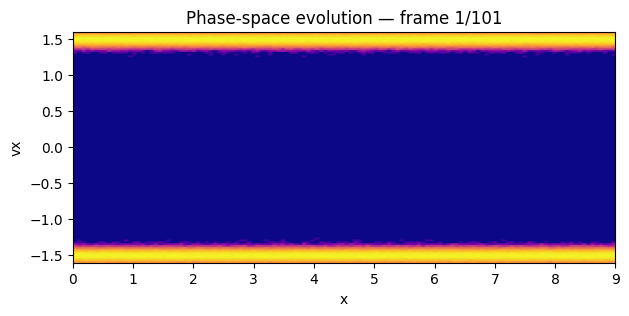

In [7]:
# diagnostics/make_phase_movie_html.py
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from diag_utils import ensure_dir
from config_paths import OUT, FIGS
from IPython.display import HTML

# 自动创建输出目录
files = sorted(glob.glob(os.path.join(OUT, "phase_*.npz")))
if not files:
    raise FileNotFoundError("❌ 未找到 phase_*.npz 文件，请先运行模拟。")

# 图设置
fig, ax = plt.subplots(figsize=(7,3))
im = None

def draw(i):
    d = np.load(files[i])
    H = d["H"]; xedges, vedges = d["xedges"], d["vedges"]

    # 优先使用诊断保存的 meta（新数据会有）
    vmin = vedges[0]; vmax = vedges[-1]
    if "meta" in d:
        vmin, vmax, nsamp = d["meta"]
    else:
        # 老数据：自动裁到非零区，尽量看清楚
        nz = np.argwhere(H > 0)
        if nz.size > 0:
            ix0, iv0 = nz.min(axis=0)
            ix1, iv1 = nz.max(axis=0)
            # 只改纵轴范围；横轴仍显示全域
            vmin, vmax = vedges[iv0], vedges[iv1+1]

    ax.clear()
    im = ax.imshow(np.log10(H.T + 1.0), origin="lower",
                   extent=[xedges[0], xedges[-1], vmin, vmax],
                   aspect="auto", cmap="plasma")
    ax.set_xlabel("x"); ax.set_ylabel("vx")
    ax.set_title(f"Phase-space evolution — frame {i+1}/{len(files)}")
    return [im]


ani = FuncAnimation(fig, draw, frames=len(files), interval=120, blit=False)

# 保存为 HTML（可交互）
html_path = os.path.join(FIGS, "phase_evolution.html")
html_str = ani.to_jshtml()
# with open(html_path, "w", encoding="utf-8") as f:
#     f.write(html_str)
# print(f"✅ 已保存交互式动画: {html_path}")

# 在 Jupyter/VSCode 中预览（可选）
try:
    display(HTML(html_str))
except Exception:
    print("ℹ️ 可手动在浏览器中打开 HTML 查看动画。")


In [12]:
import numpy as np
path = os.path.join(OUT, "phase_00200.npz")
d = np.load(path)
H = d["H"]; xedges = d["xedges"]; vedges = d["vedges"]
print("H shape:", H.shape, "sum counts:", H.sum())
print("v range used:", (vedges[0], vedges[-1]))

import glob, numpy as np, os
rows = []
for f in sorted(glob.glob(os.path.join(OUT, "phase_*.npz"))):
    d = np.load(f)
    H = d["H"]; v = d["vedges"]
    cnt = int(H.sum())
    rows.append((os.path.basename(f), cnt, (float(v[0]), float(v[-1]))))
for name, cnt, vr in rows[:10]:
    print(name, "counts:", cnt, "v-range:", vr)



H shape: (128, 100) sum counts: 18.0
v range used: (np.float64(-2.0), np.float64(2.0))
phase_00000.npz counts: 200000 v-range: (-2.0, 2.0)
phase_00050.npz counts: 17 v-range: (-2.0, 2.0)
phase_00100.npz counts: 18 v-range: (-2.0, 2.0)
phase_00150.npz counts: 24 v-range: (-2.0, 2.0)
phase_00200.npz counts: 18 v-range: (-2.0, 2.0)
phase_00250.npz counts: 12 v-range: (-2.0, 2.0)
phase_00300.npz counts: 23 v-range: (-2.0, 2.0)
phase_00350.npz counts: 22 v-range: (-2.0, 2.0)
phase_00400.npz counts: 21 v-range: (-2.0, 2.0)
phase_00450.npz counts: 18 v-range: (-2.0, 2.0)


In [10]:
# spectrum_diag.py
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from diag_utils import ensure_dir, list_spectrum_files, load_spectrum, detect_kmax, robust_linear_fit, unwrap_phase, save_txt

# OUT = "output"
# FIGS = ensure_dir(os.path.join(OUT, "figs"))

files = list_spectrum_files(OUT)
# 读取所有帧谱
Ks = None
Pk_list = []
Ek_list = []
for f in files:
    k, Ek, Pk = load_spectrum(f)
    if Ks is None:
        Ks = k
    Pk_list.append(Pk)
    Ek_list.append(Ek)
Pk_arr = np.stack(Pk_list, axis=0)   # shape: [T, K]
Ek_arr = np.stack(Ek_list, axis=0)   # complex [T, K]
T, K = Pk_arr.shape
steps = np.arange(T)

# 1) k–t 热图（log10|E_k|^2）
plt.figure(figsize=(7,4))
plt.imshow(np.log10(Pk_arr + 1e-30).T, origin="lower", aspect="auto",
           extent=[0, T-1, Ks[0], Ks[-1]])
plt.xlabel("Time index (diagnostic frames)"); plt.ylabel("k")
plt.title("E-field Spectrum evolution (log10 |E_k|^2)")
plt.colorbar(label="log10 |E_k|^2")
png1 = os.path.join(FIGS, "spectrum_k_t.png")
plt.tight_layout(); plt.savefig(png1, dpi=150)
print(f"Saved {png1}")

# 2) 选择若干模式，画 |E_k| 随时间
select_k_indices = []
# 选三四个等距模式（可按需修改）
for frac in [0.2, 0.4, 0.6, 0.8]:
    select_k_indices.append(int(frac*(K-1)))
select_k_indices = sorted(set(select_k_indices))

plt.figure(figsize=(7,4))
for idx in select_k_indices:
    amp = np.abs(Ek_arr[:, idx])
    plt.plot(steps, amp, label=f"k={Ks[idx]:.3f}")
plt.xlabel("Time index"); plt.ylabel("|E_k| (amplitude)")
plt.title("Selected Mode Amplitudes")
plt.legend(); plt.tight_layout()
png2 = os.path.join(FIGS, "spectrum_selected_modes.png")
plt.savefig(png2, dpi=150)
print(f"Saved {png2}")

# 3) 自动检测主导模式 kmax（平均前几帧）
kmax_idx, kmax_val, k_axis = detect_kmax(files, skip_dc=True, avg_frames=5)
Ak = np.abs(Ek_arr[:, kmax_idx])
ph = unwrap_phase(np.angle(Ek_arr[:, kmax_idx]))

# 拟合主导模式增长率（幅度 ~ e^{γ t}）
aA, bA = robust_linear_fit(steps, np.log(np.maximum(Ak, 1e-30)), frac=1/3, min_pts=6)
gamma_kmax = bA if np.isfinite(bA) else np.nan  # amplitude ~ e^{γ t}

# 拟合主导模式频率（相位斜率）
aP, bP = robust_linear_fit(steps, ph, frac=1/3, min_pts=6)
omega_kmax = bP if np.isfinite(bP) else np.nan  # rad / (diagnostic frame)

# 图：主导模式幅度与相位
fig, ax = plt.subplots(2,1, figsize=(7,6), sharex=True)
ax[0].plot(steps, Ak)
ax[0].set_ylabel("|E_kmax|")
ax[0].set_title(f"Dominant mode k_max={kmax_val:.4f},  gamma≈{gamma_kmax:.3e} (per frame)")

ax[1].plot(steps, ph)
ax[1].set_xlabel("Time index (diagnostic frames)")
ax[1].set_ylabel("phase (rad)")
ax[1].set_title(f"Phase slope ω≈{omega_kmax:.3e} rad/frame")
plt.tight_layout()
png3 = os.path.join(FIGS, "spectrum_kmax_amp_phase.png")
plt.savefig(png3, dpi=150)
print(f"Saved {png3}")

# 写汇总
txt = (
    "# Spectrum/growth summary\n"
    f"kmax_index = {kmax_idx}\n"
    f"kmax_value = {kmax_val:.8e}\n"
    f"gamma_kmax (amplitude fit) = {gamma_kmax:.8e}  # per diagnostic frame\n"
    f"omega_kmax (phase slope)   = {omega_kmax:.8e}  # rad per diagnostic frame\n"
)
save_txt(os.path.join(OUT, "growth_from_spectrum.txt"), txt)
print(txt)


ValueError: all input arrays must have the same shape

Saved c:\QIEN\Work\学习\教材\物理\细分领域\Numrical Physics\project\twostream\output\figs\growth_total_vs_kmax.png
# Growth comparison summary
gamma_total (from energy)      = -2.35355612e+00  (per step)
kmax_value                     = 1.00000000e+00
gamma_kmax (from |E_k| amp)    = 1.69699539e+01  (per spectrum frame)
omega_kmax (from phase slope)  = -4.88665548e+00  (rad per spectrum frame)



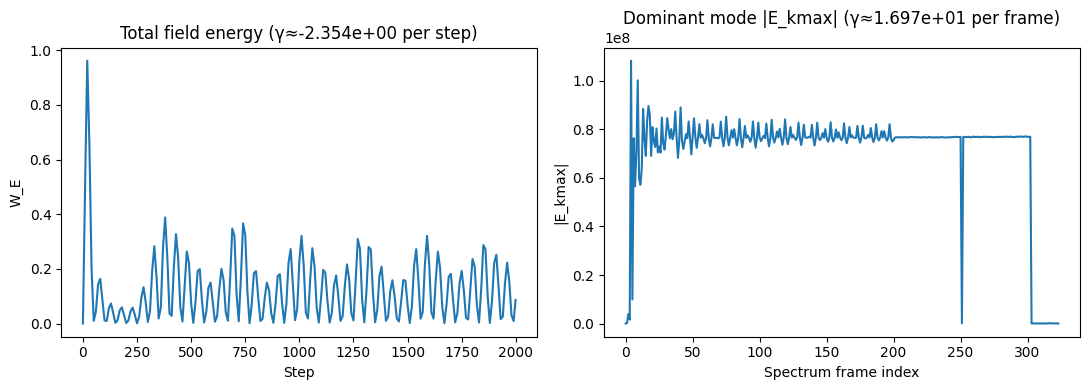

In [11]:
# growth_compare.py
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from diag_utils import ensure_dir, load_energy, list_spectrum_files, load_spectrum, detect_kmax, robust_linear_fit, unwrap_phase, save_txt

# OUT = "output"
# FIGS = ensure_dir(os.path.join(OUT, "figs"))

# 总场（用 W_E）
E = load_energy(OUT)
tE, WE = E[:,0], E[:,1]
a_tot, b_tot = robust_linear_fit(tE, np.log(np.maximum(WE,1e-30)), frac=1/3, min_pts=6)
gamma_total = 0.5*b_tot if np.isfinite(b_tot) else np.nan  # ln WE ~ 2γ t

# 主导模式（用谱）
files = list_spectrum_files(OUT)
kmax_idx, kmax_val, k_axis = detect_kmax(files, skip_dc=True, avg_frames=5)
# 逐帧加载主导模式
A_list = []; P_list = []
for f in files:
    k, Ek, Pk = load_spectrum(f)
    A_list.append(np.abs(Ek[kmax_idx]))
    P_list.append(np.angle(Ek[kmax_idx]))
A, P = np.array(A_list), unwrap_phase(np.array(P_list))
steps = np.arange(len(files))

aA, bA = robust_linear_fit(steps, np.log(np.maximum(A,1e-30)), frac=1/3, min_pts=6)
gamma_kmax = bA if np.isfinite(bA) else np.nan
aP, bP = robust_linear_fit(steps, P, frac=1/3, min_pts=6)
omega_kmax = bP if np.isfinite(bP) else np.nan

# 画图
fig, ax = plt.subplots(1,2, figsize=(11,4))
ax[0].plot(tE, WE)
ax[0].set_title(f"Total field energy (γ≈{gamma_total:.3e} per step)")
ax[0].set_xlabel("Step"); ax[0].set_ylabel("W_E")

ax[1].plot(steps, A)
ax[1].set_title(f"Dominant mode |E_kmax| (γ≈{gamma_kmax:.3e} per frame)")
ax[1].set_xlabel("Spectrum frame index"); ax[1].set_ylabel("|E_kmax|")
plt.tight_layout()
png = os.path.join(FIGS, "growth_total_vs_kmax.png")
plt.savefig(png, dpi=150)
print(f"Saved {png}")

txt = (
    "# Growth comparison summary\n"
    f"gamma_total (from energy)      = {gamma_total:.8e}  (per step)\n"
    f"kmax_value                     = {kmax_val:.8e}\n"
    f"gamma_kmax (from |E_k| amp)    = {gamma_kmax:.8e}  (per spectrum frame)\n"
    f"omega_kmax (from phase slope)  = {omega_kmax:.8e}  (rad per spectrum frame)\n"
)
save_txt(os.path.join(OUT, "growth_compare.txt"), txt)
print(txt)
